# Decoding Responsivity
**Can we predict whether a stimulus will be detected or not based on neuron's responsivity ?**

Célien Vandromme
18/04/2024

---

## Modules & data import

---

In [218]:
import numpy as np
import pandas as pd

import percephone.core.recording as pc
import os
import matplotlib
import percephone.plts.stats as ppt
import matplotlib.pyplot as plt
from multiprocessing import Pool, cpu_count, pool
import warnings
import seaborn as sns
import copy

plt.rcParams['font.size'] = 10
plt.rcParams['axes.linewidth'] = 2
plt.switch_backend("Qt5Agg")
matplotlib.use("Qt5Agg")
%matplotlib inline
warnings.filterwarnings('ignore')
fontsize = 20

In [219]:
directory = "C:/Users/cvandromme/Desktop/Data/"
roi_info = pd.read_excel("C:/Users/cvandromme/Desktop/FmKO_ROIs&inhibitory.xlsx")
files = os.listdir(directory)
files_ = [file for file in files if file.endswith("synchro")]

In [220]:
def opening_rec(fil,i):
    rec = pc.RecordingAmplDet(directory + fil + "/", 0, fil, roi_info)
    rec.peak_delay_amp()
    return rec

In [221]:
workers = cpu_count()
pool = pool.ThreadPool(processes=workers)
async_results = [pool.apply_async(opening_rec, args=(file,i)) for i,file in enumerate(files_)]
recs = {ar.get().filename: ar.get() for ar in async_results}

Behavioural information already incorporated in the analog.
Behavioural information already incorporated in the analog.
Behavioural information already incorporated in the analog.
Behavioural information already incorporated in the analog.
Behavioural information already incorporated in the analog.
Behavioural information already incorporated in the analog.
Behavioural information already incorporated in the analog.
Behavioural information already incorporated in the analog.
Behavioural information already incorporated in the analog.
Behavioural information already incorporated in the analog.
Behavioural information already incorporated in the analog.
Behavioural information already incorporated in the analog.
Behavioural information already incorporated in the analog.
Behavioural information already incorporated in the analog.


## Logistic regression

---

In [222]:
def group_exc_inh(rec, parameter, label=False, invert_inh=False):
    exc = rec.matrices["EXC"][parameter]
    inh = rec.matrices["INH"][parameter]
    
    if invert_inh:
        inh = -2 * inh
        
    if label:
        exc_col = np.ones(exc.shape[0])
        inh_col = np.zeros(inh.shape[0])
    
        exc = np.column_stack((exc_col, exc))
        inh = np.column_stack((inh_col, inh))
        
    return np.row_stack((exc, inh))

The following piece of code only works for records that have the same number of stimulations

In [223]:
def group_ind(recs, parameter, exc_neuron=True, inh_neuron=False, test_size=0.8):
    first_record = True
    for rec in recs.values():
        y = rec.detected_stim
        if exc_neuron and inh_neuron:
            exc = rec.matrices["EXC"][parameter].T
            inh = rec.matrices["INH"][parameter].T
            exc_X_train, exc_X_test, exc_y_train, exc_y_test = train_test_split(exc, y, train_size=test_size)
            inh_X_train, inh_X_test, inh_y_train, inh_y_test = train_test_split(inh, y, train_size=test_size)
            X_train = np.column_stack((exc_X_train, inh_X_train))
            X_test = np.column_stack((exc_X_test, inh_X_test))
            y_train = np.column_stack((exc_y_train, inh_y_train))
            y_test = np.column_stack((exc_y_test, inh_y_test))
        elif exc_neuron or inh_neuron:
            if exc_neuron:  
                single = rec.matrices["EXC"][parameter].T
            else:
                single = rec.matrices["INH"][parameter].T
            X_train, X_test, y_train, y_test = train_test_split(single, y, train_size=test_size)
            
        if first_record:
            gX_train = X_train
            gX_test = X_test
            gy_train = y_train
            gy_test = y_test
            first_record = False
        else:
            gX_train = np.column_stack((gX_train, X_train))
            gX_test = np.column_stack((gX_test, X_test))
            gy_train = np.column_stack((gy_train, y_train))
            gy_test = np.column_stack((gy_test, y_test))
    return gX_train, gX_test, gy_train, gy_test

In [224]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, train_test_split
%config InlineBackend.figure_format = 'retina'
# plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/main/nma.mplstyle")

In [421]:
def plot_weights(models, sharey=True):
    """Draw a stem plot of weights for each model in models dict."""
    n = len(models)
    f = plt.figure(figsize=(8, n))
    axs = f.subplots(n, sharex=True, sharey=sharey)
    axs = np.atleast_1d(axs)

    for ax, (title, model) in zip(axs, models.items()):

        ax.margins(x=.02)
        stem = ax.stem(model.coef_.squeeze())
        stem[0].set_marker(".")
        stem[0].set_color(".2")
        stem[1].set_linewidths(.5)
        stem[1].set_color(".2")
        stem[2].set_visible(False)
        ax.axhline(0, color="C3", lw=1)
        ax.set(ylabel="Weight", title=title)
    ax.set(xlabel="Neuron (a.k.a. feature)")
    f.tight_layout()
    plt.show()

In [429]:
def apply_model(recs, parameter, model, cv=10, test_size=0.8, exc_neurons=True, inh_neurons=False, weights=False):
    mean_accuracies = []
    test_accuracies = []
    genotype_list = []
    models_dict = {}
    
    fig, ax = plt.subplots(nrows=8, ncols=2, figsize=(8, 5), sharex=True)
    i_wt = 0
    i_ko = 0
    
    for rec in recs.values():
        # Defining X and other parameters
        if exc_neurons and inh_neurons:
            X = group_exc_inh(rec, parameter, invert_inh=False).T
            title_var = "EXC & INH"
        elif exc_neurons:
            X = rec.matrices["EXC"][parameter].T
            title_var = "EXC"
        elif inh_neurons:
            X = rec.matrices["INH"][parameter].T
            title_var = "INH"
        y = rec.detected_stim
        
        # Splitting between train and test data
        X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=test_size)
        model.fit(X_train, y_train)
        
        # Saving model for plotting the weights
        models_dict[f"{rec.filename} ({rec.genotype})"] = copy.copy(model)
        
        # Cross-validation
        accuracies = cross_val_score(model, X_train, y_train, cv=cv)
        mean_accuracies.append(accuracies.mean())
        genotype_list.append(rec.genotype)
        
        # Accuracy on test data
        y_pred = model.predict(X_test)
        test_accuracy = (y_test == y_pred).sum() / len(y_test)
        test_accuracies.append(test_accuracy)
        
        if rec.genotype == "WT":
            i = copy.copy(i_wt)
            j = 0
            i_wt += 1
        else:
            i = copy.copy(i_ko)
            j = 1
            i_ko += 1
        
        # Boxplot
        ax[i, j].boxplot(accuracies, vert=False, widths=.5)
        ax[i, j].scatter(accuracies, np.ones(cv), s=10)
        ax[i, j].set(
          yticks=[],
          title=f"{rec.filename} Average cv accuracy: {accuracies.mean():.2%} ({rec.genotype}) - {test_accuracy:.2%}"
        )
        ax[i, j].set_title(f"{rec.filename} ({rec.genotype}) - Average accuracy: CV({accuracies.mean():.2%}) Test({test_accuracy:.2%})", size=10)
        ax[i, j].spines["left"].set_visible(False)
    plt.suptitle(f"Decoding {parameter} for {title_var} neurons - Test size: {test_size:.1%} - CV: {cv} fold")
    plt.show()
    
    df = pd.DataFrame({
        'genotype': genotype_list,
        'mean_accuracy': mean_accuracies,
        'test_accuracy': test_accuracies
    })
    df_melted = df.melt(id_vars='genotype', var_name='accuracy_type', value_name='accuracy')
    
    plt.figure(figsize=(8, 5))
    sns.boxplot(x='genotype', y='accuracy', hue='accuracy_type', data=df_melted)
    plt.title('Accuracy by Genotype and Type')
    plt.show()
  
    if weights:
        plot_weights(models_dict)

### Searching best C value

In [273]:
def lr_c_value_selection(X, y, c_values, cv=10):
    accuracies = []
    for c in c_values:
        model = LogisticRegression(penalty="l2", max_iter=5000, C=c)
        model.fit(X, y)
        accs = cross_val_score(model, X, y, cv=cv)
        accuracies.append(accs.mean())
    return accuracies

In [274]:
def plot_c_values(c_values, train_size=0.8, cv=10):
    mod_acc_list = []
    mod_best_c_list =[]
    genotype_list = []
    color = {"WT": "blue", "KO": "red", "KO-Hypo": "pink"}
    
    for rec in recs.values():
        x_train, _, y_train, _ = train_test_split(rec.matrices["EXC"]["Responsivity"].T, rec.detected_stim, train_size=train_size)
        acc = lr_c_value_selection(x_train, y_train, c_values, cv=cv)
        mod_acc_list.append(acc)
        genotype_list.append(rec.genotype)
        mod_best_c_list.append(c_values[np.argmax(acc)])
    
    plt.figure(figsize=(6, 4))
    for i, rec in enumerate(mod_acc_list):
        plt.plot(c_values, mod_acc_list[i], color=color[genotype_list[i]], label=f"best C: {mod_best_c_list[i]}")
    plt.xscale("log")
    plt.xlabel("C")
    plt.ylabel("Cross-validated accuracy")
    plt.legend(loc="upper right")
    plt.show()

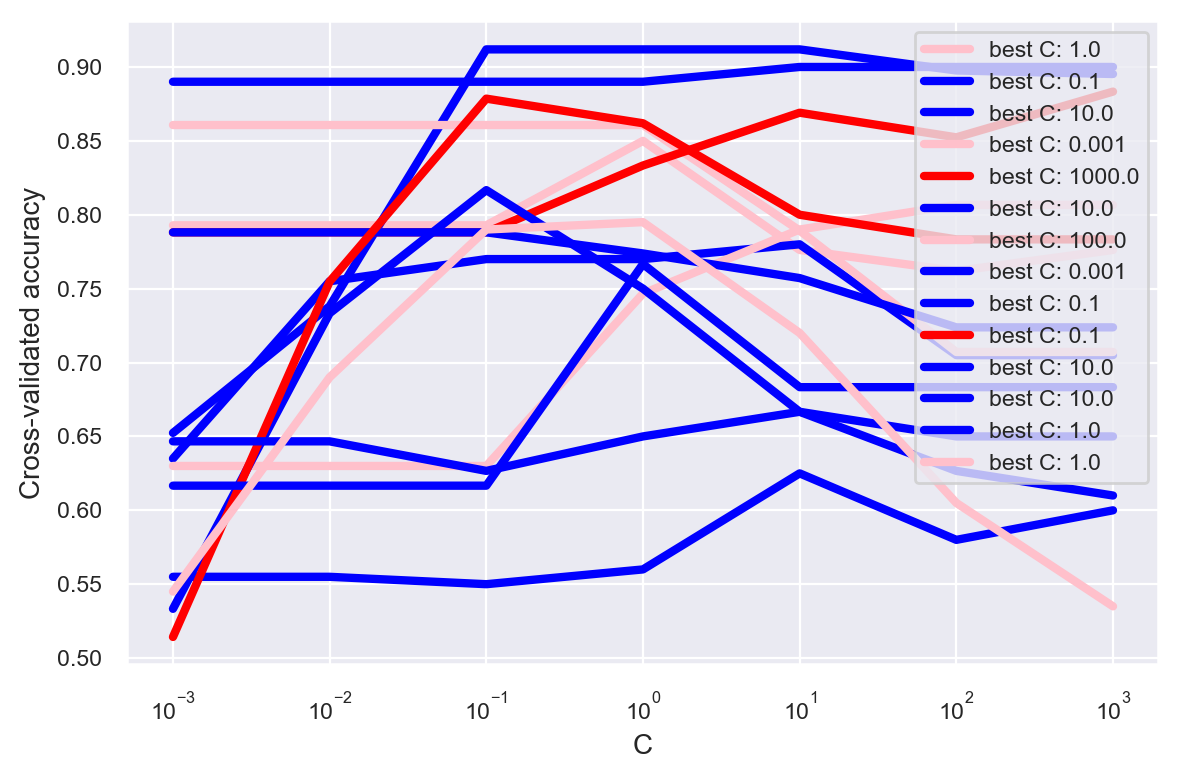

In [285]:
c_values = np.logspace(-3, 3, 7)
plot_c_values(c_values)

### Modelling

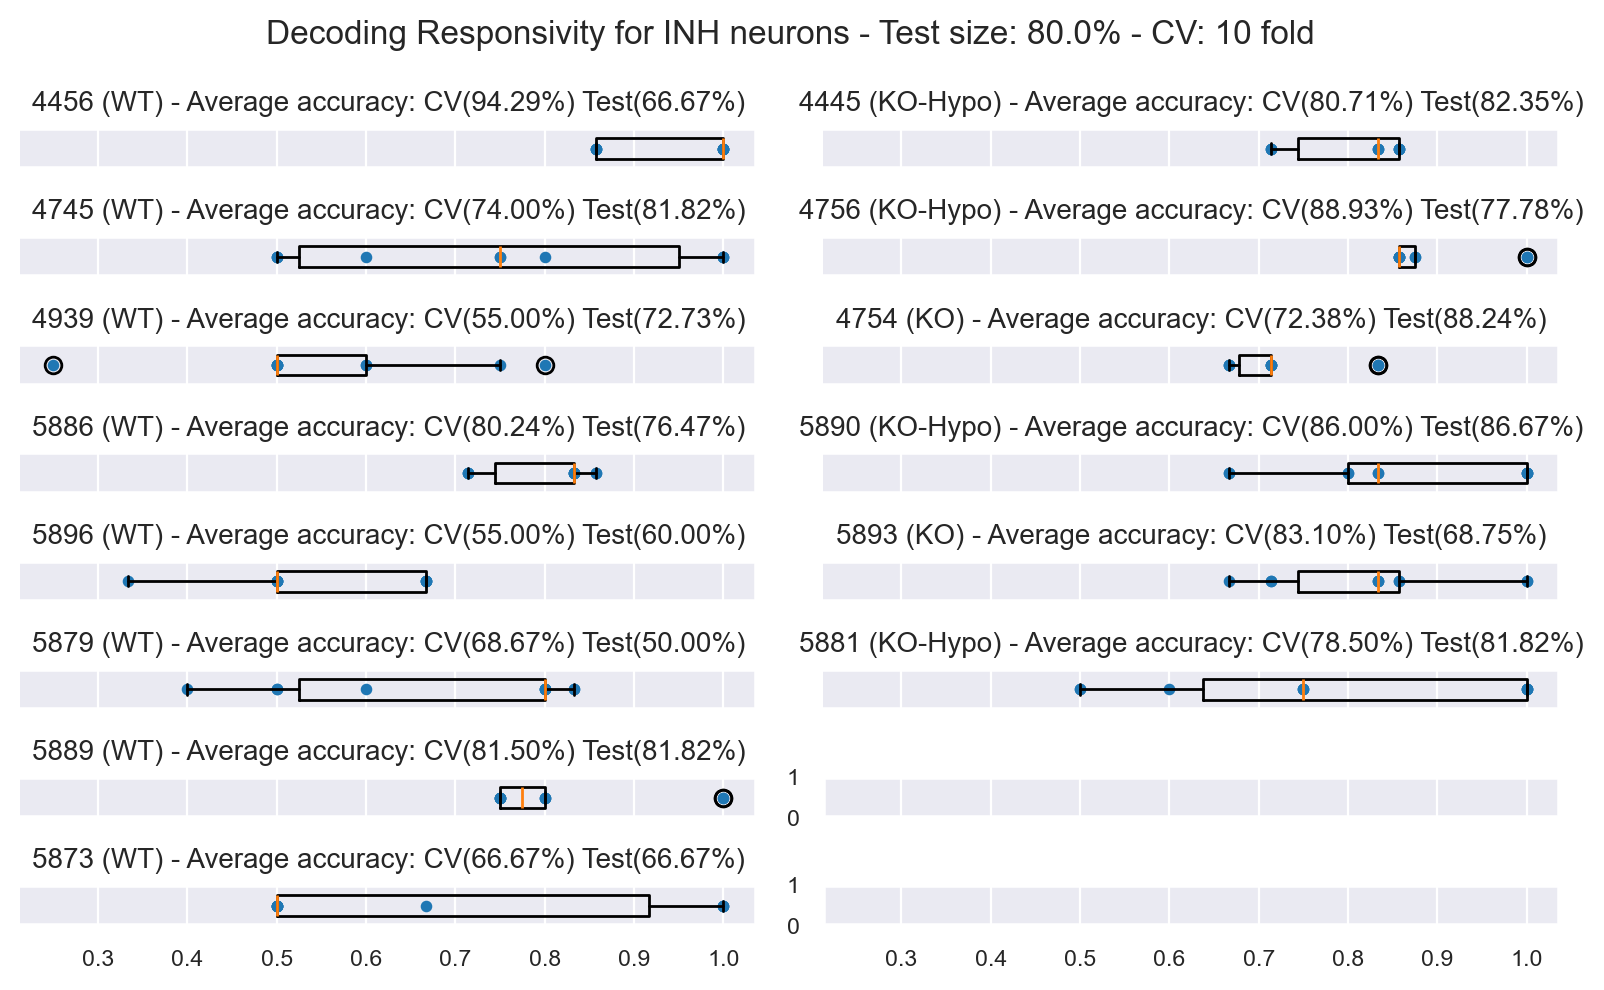

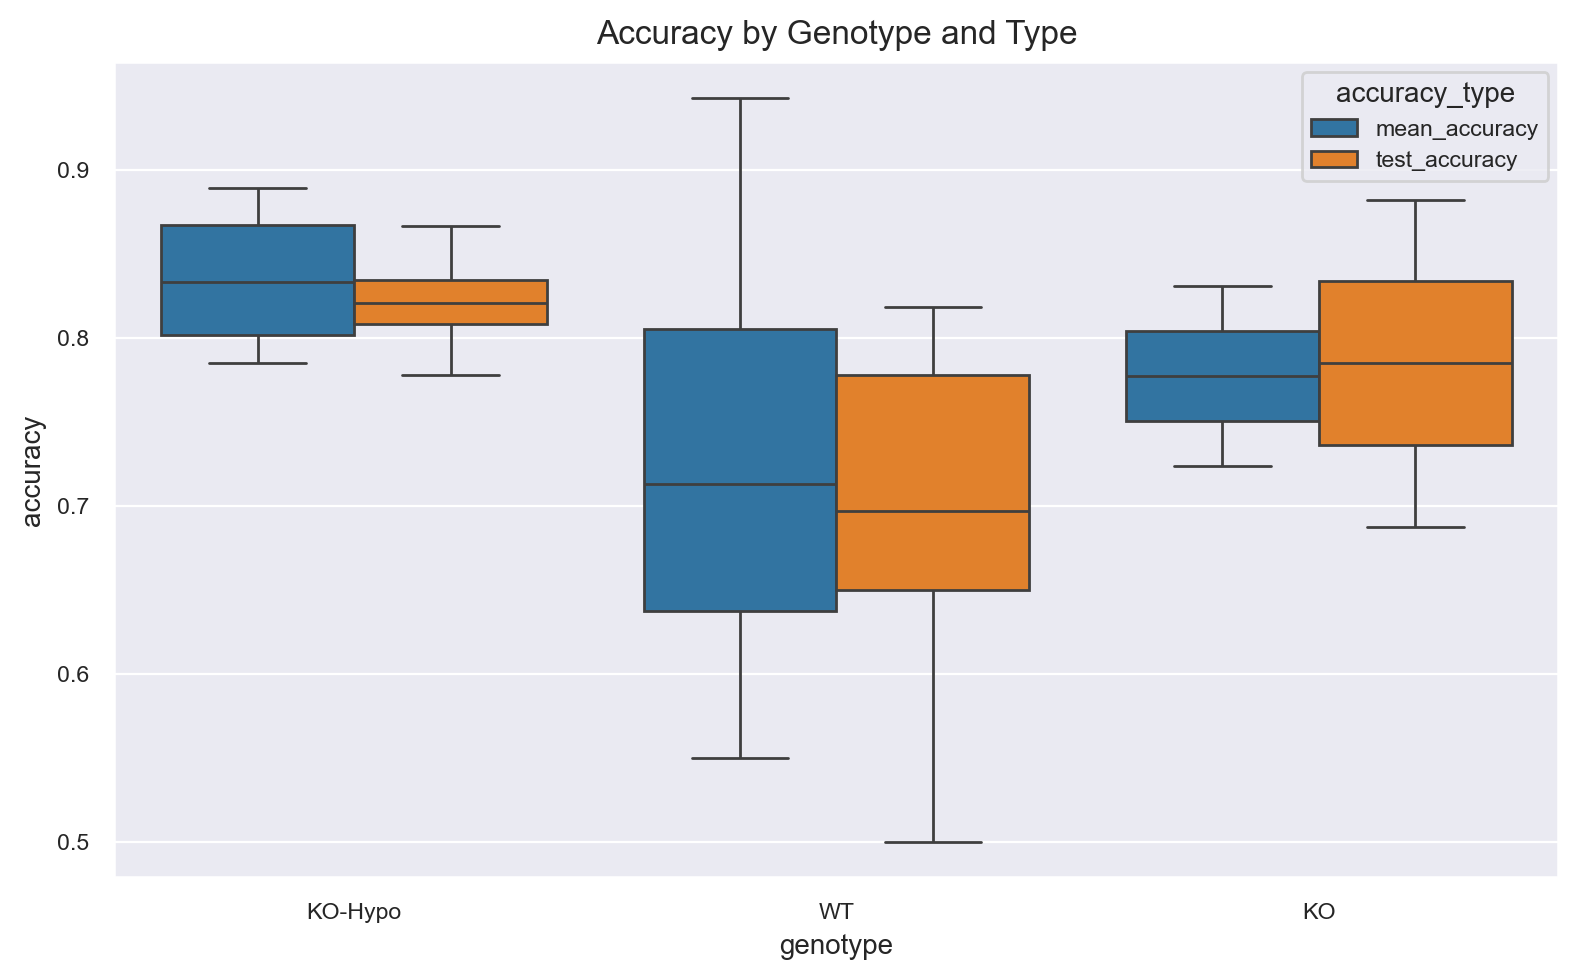

In [387]:
log_mod = LogisticRegression(penalty="l2", C=1)
apply_model(recs, "Responsivity", log_mod, exc_neurons=False, inh_neurons=True, test_size=0.8, cv=10)

# Encoding pre-stimulus activity

---

In [340]:
def neuron_mean_std_corr(array, estimator):
    if estimator == "Mean":
        return np.mean(array, axis=0)
    if estimator == "Std":
        return np.std(array, axis=0)

In [448]:
def randomize_array_order(array):
    permuted_indices = np.random.permutation(len(array))
    arr_permuted = array[permuted_indices]
    return arr_permuted

In [483]:
def apply_model_2(recs, estimator, model, nb_frames=30, cv=10, train_size=0.8, 
                  exc_neurons=True, 
                  inh_neurons=False, 
                  stim_ampl=True,
                  weights=False, 
                  randomize_neuron_order=False, 
                  random_target=False):
    mean_accuracies = []
    test_accuracies = []
    genotype_list = []
    models_dict = {}
    
    fig, ax = plt.subplots(nrows=8, ncols=2, figsize=(8, 5), sharex=True)
    i_wt = 0
    i_ko = 0

    for rec in recs.values():
        # Getting the zscore corresponding to the neuron type
        if exc_neurons and inh_neurons:
            zscore = np.row_stack((rec.zscore_exc, rec.zscore_inh)).T
            title_var = "EXC & INH"
        elif exc_neurons:
            zscore = rec.zscore_exc.T
            title_var = "EXC"
        elif inh_neurons:
            zscore = rec.zscore_inh.T
            title_var = "INH"
        
        # Setting a random target to test the model
        if random_target:
            y = np.random.choice([True, False], size=rec.detected_stim.shape)
        else:
            y = rec.detected_stim
        
        # Creating the X array by combining stimulation amplitude and pre-stimulus activity
        X = rec.stim_ampl
        first = True
        for i in range(X.shape[0]):
            start = rec.stim_time[i] - nb_frames
            end = rec.stim_time[i]
            if first:
                pre_stim = neuron_mean_std_corr(zscore[start : end], estimator)
                first = False
            else:
                new_row = neuron_mean_std_corr(zscore[start : end], estimator)
                if randomize_neuron_order:
                    pre_stim = np.row_stack((pre_stim, randomize_array_order(new_row)))
                else:
                    pre_stim = np.row_stack((pre_stim, new_row))
        if stim_ampl:
            X = np.column_stack((X, pre_stim))
        else:
            X = pre_stim

        # Splitting between train and test data
        X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_size)
        model.fit(X_train, y_train)
        
        # Saving model for plotting the weights
        models_dict[f"{rec.filename} ({rec.genotype})"] = copy.copy(model)
        
        # Cross-validation
        accuracies = cross_val_score(model, X_train, y_train, cv=cv)
        mean_accuracies.append(accuracies.mean())
        genotype_list.append(rec.genotype)
        
        # Accuracy on test data
        y_pred = model.predict(X_test)
        test_accuracy = (y_test == y_pred).sum() / len(y_test)
        test_accuracies.append(test_accuracy)
        
        # Boxplot of each recording
        if rec.genotype == "WT":
            i = copy.copy(i_wt)
            j = 0
            i_wt += 1
        else:
            i = copy.copy(i_ko)
            j = 1
            i_ko += 1
        
        ax[i, j].boxplot(accuracies, vert=False, widths=.5)
        ax[i, j].scatter(accuracies, np.ones(cv), s=10)
        ax[i, j].set(
          yticks=[],
          title=f"{rec.filename} Average cv accuracy: {accuracies.mean():.2%} ({rec.genotype}) - {test_accuracy:.2%}"
        )
        ax[i, j].set_title(f"{rec.filename} ({rec.genotype}) - Average accuracy: CV({accuracies.mean():.2%}) Test({test_accuracy:.2%})", size=10)
        ax[i, j].spines["left"].set_visible(False)
    plt.suptitle(f"Encoding {estimator} for {title_var} neurons ({nb_frames} frames) - Train size: {train_size:.1%} - CV: {cv} fold")
    plt.show()
    
    # Mean boxplots
    df = pd.DataFrame({
        'genotype': genotype_list,
        'mean_accuracy': mean_accuracies,
        'test_accuracy': test_accuracies
    })
    df_melted = df.melt(id_vars='genotype', var_name='accuracy_type', value_name='accuracy')
    
    plt.figure(figsize=(8, 5))
    sns.boxplot(x='genotype', y='accuracy', hue='accuracy_type', data=df_melted)
    plt.title('Accuracy by Genotype and Type')
    plt.show()
    
    # Weights plotting
    if weights:
        plot_weights(models_dict)

In [491]:
for rec in recs.values():
    print(rec.filename, rec.detected_stim.shape, rec.detected_stim.sum(), rec.genotype)

4445 (84,) 17 KO-Hypo
4456 (87,) 58 WT
4745 (55,) 25 WT
4756 (90,) 12 KO-Hypo
4754 (82,) 61 KO
4939 (54,) 25 WT
5890 (72,) 23 KO-Hypo
5886 (82,) 65 WT
5896 (75,) 38 WT
5893 (80,) 37 KO
5879 (68,) 45 WT
5889 (54,) 46 WT
5873 (27,) 19 WT
5881 (53,) 24 KO-Hypo


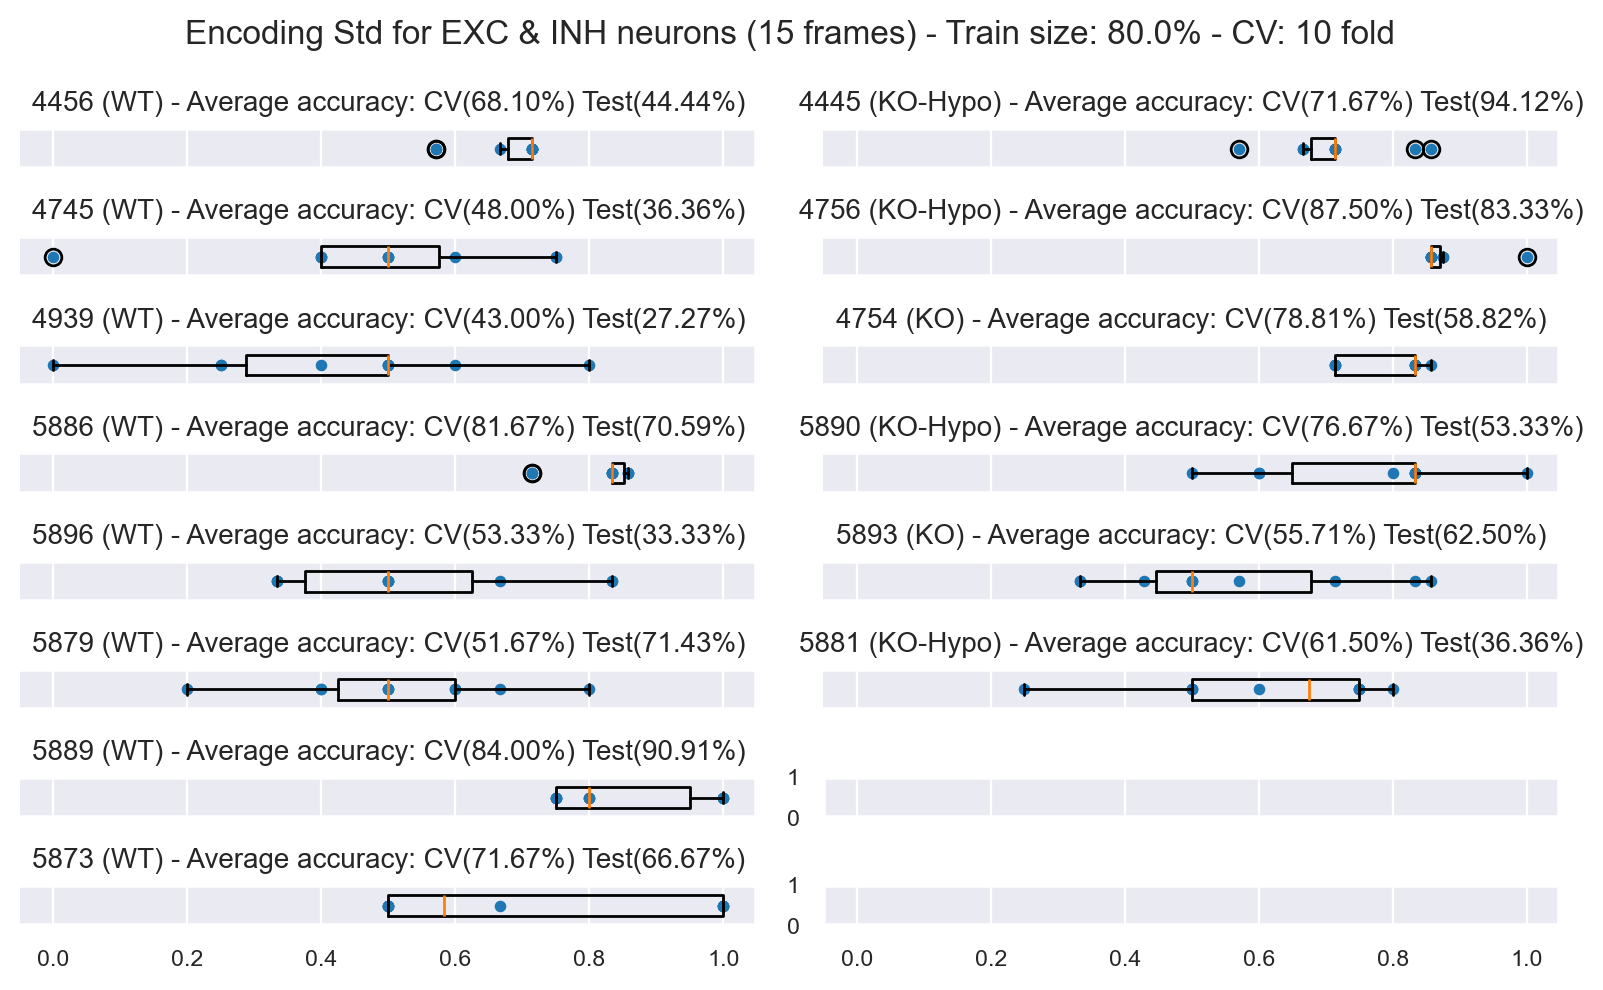

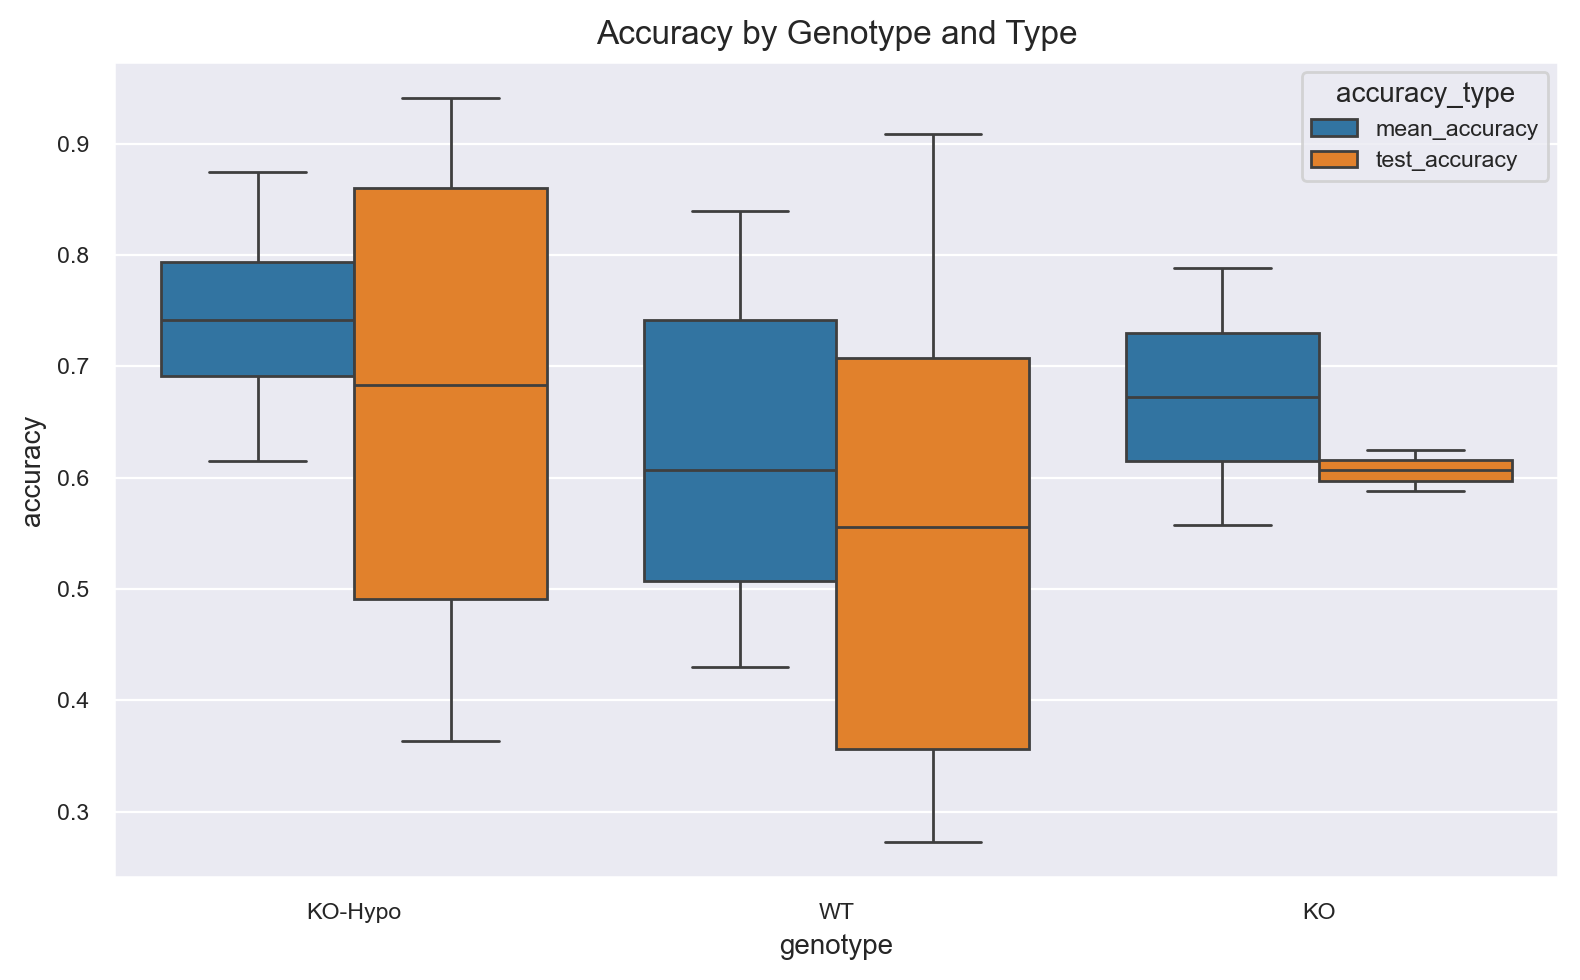

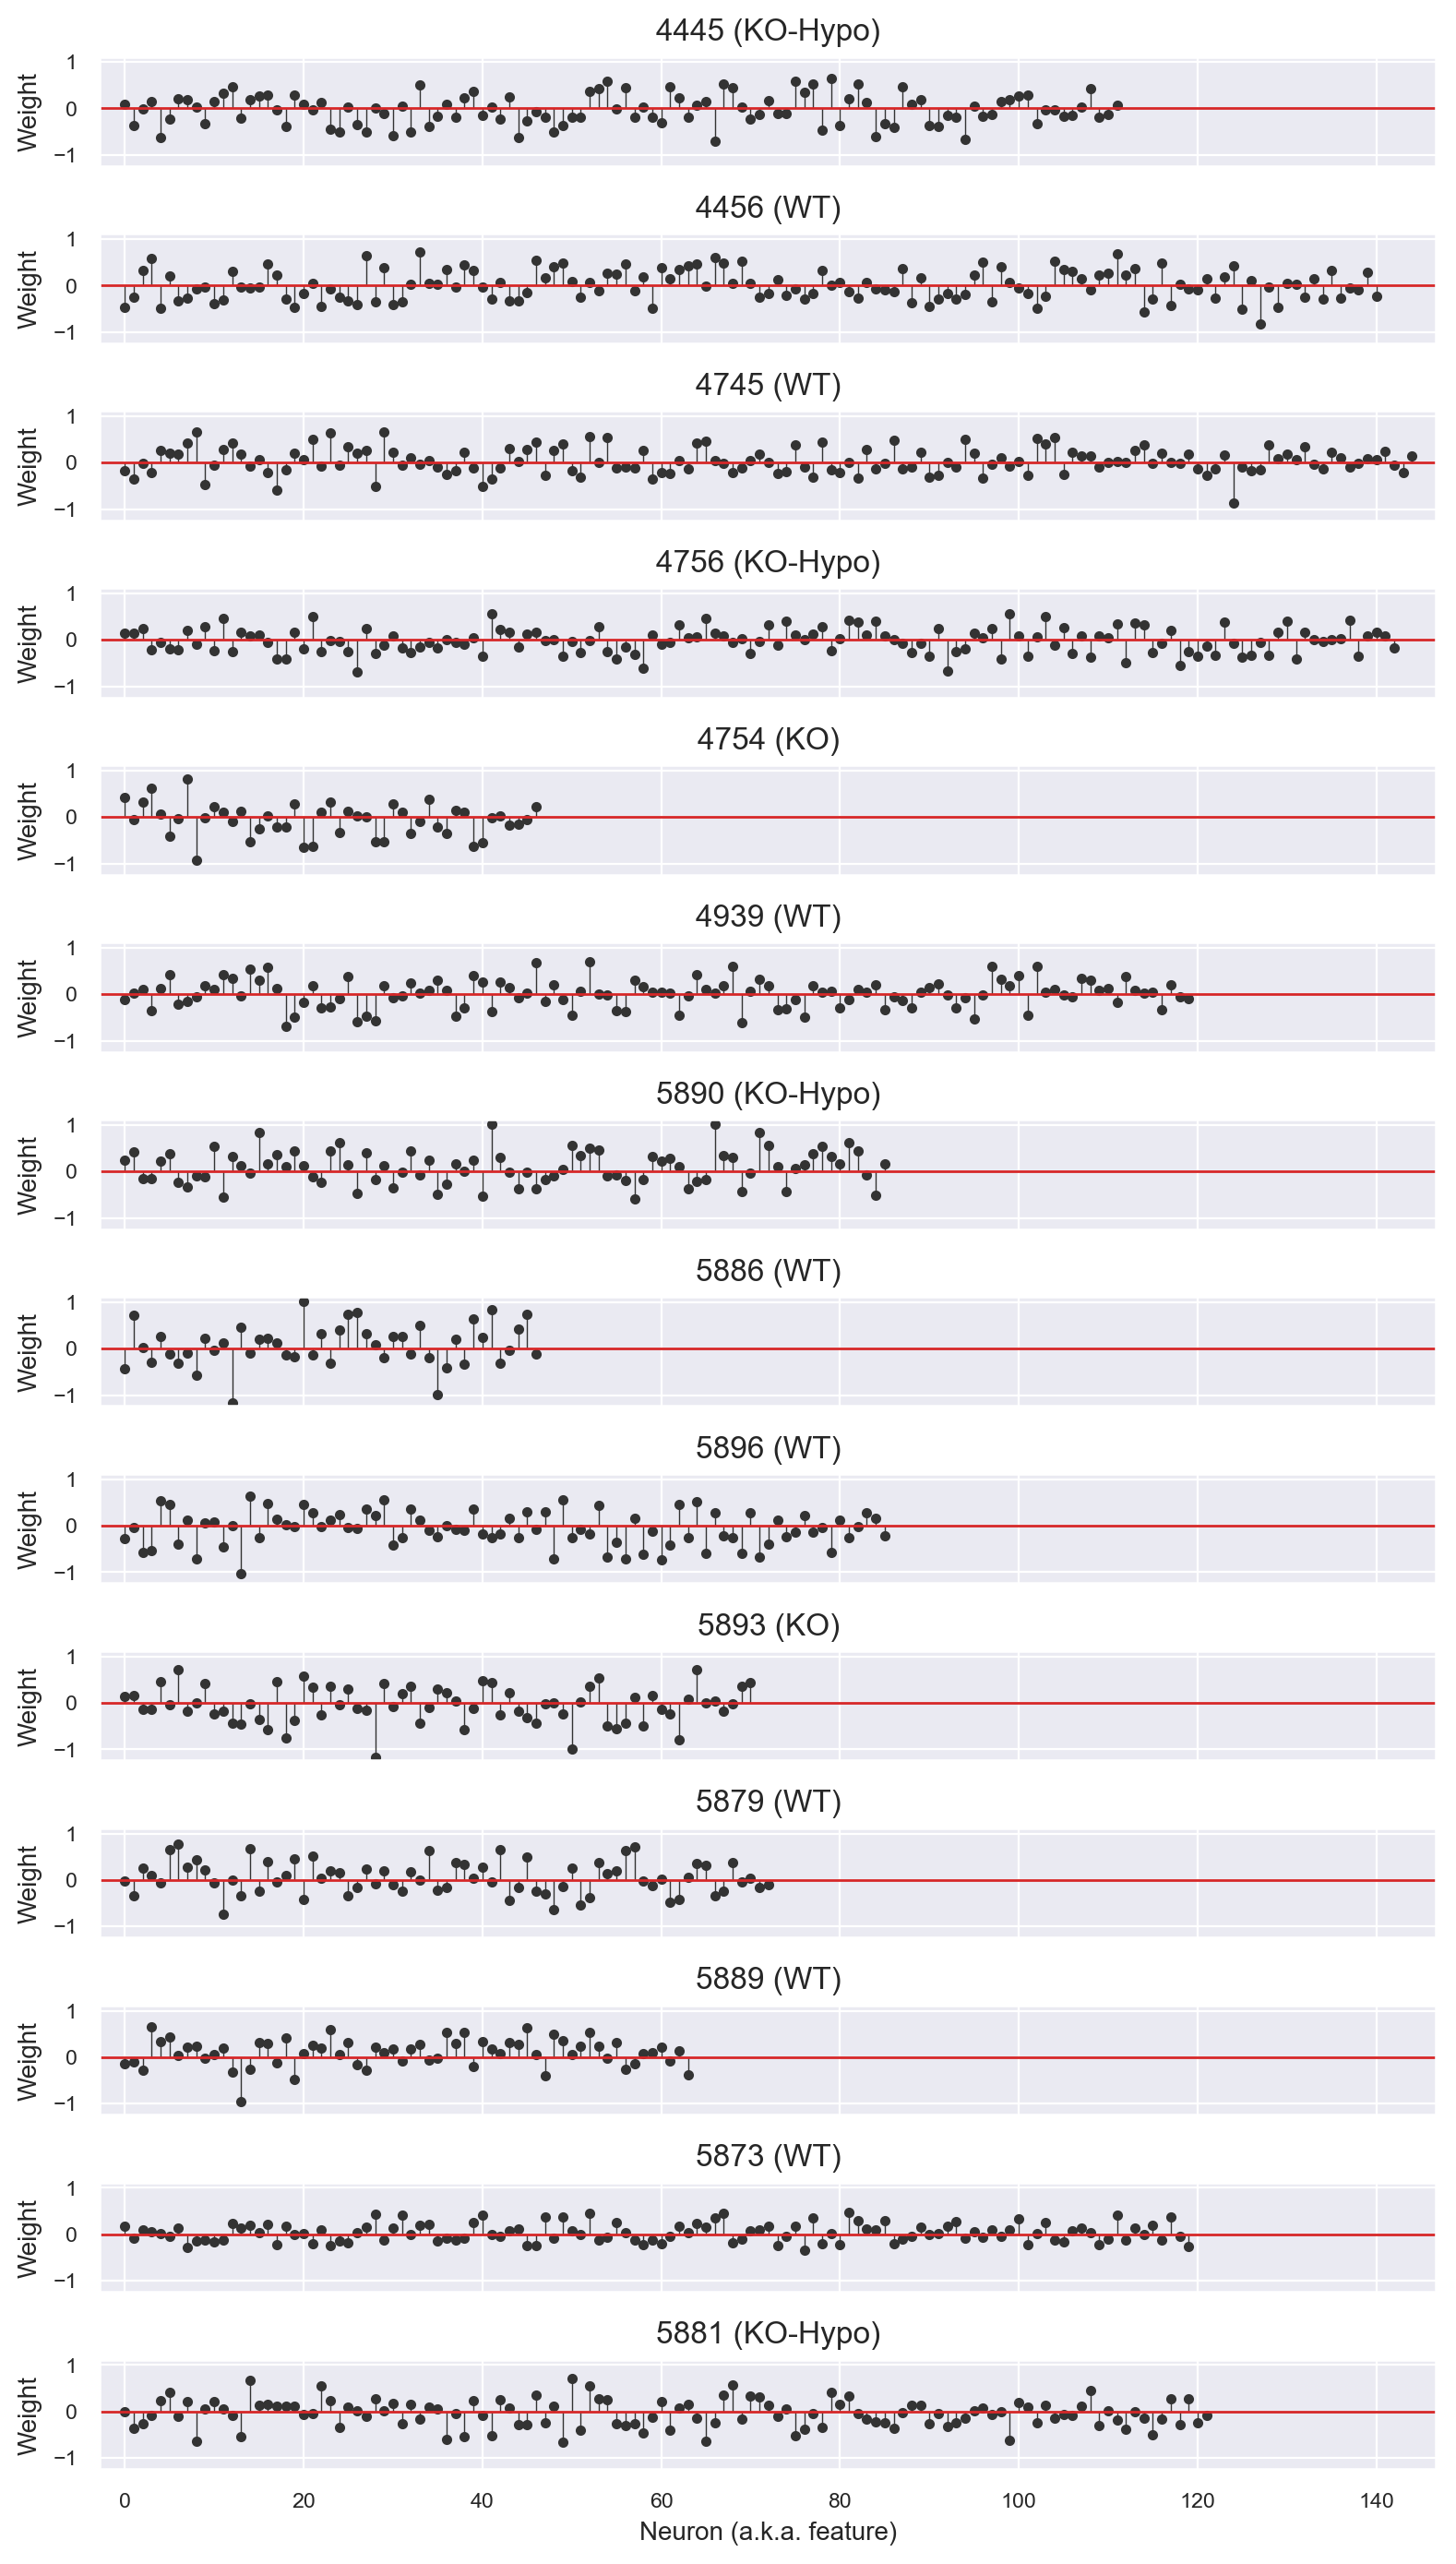

In [485]:
encoding_model = LogisticRegression(penalty="l2")
apply_model_2(recs, "Std", encoding_model, exc_neurons=True, inh_neurons=True, nb_frames=15, weights=True, random_target=False, randomize_neuron_order=False, stim_ampl=False)